# Alice

In [2]:
# загрузим библиотеки и установим опции

from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

### 1. Загрузка и преобразование данных

In [3]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/websites_train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/websites_test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [4]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'всего сайтов:', sites_dict.shape[0])
sites_dict.head()

всего сайтов: 48371


,site
13852,i1-js-14-3-01-11544-644949368-i.init.cedexis-r...
6240,static.vol24.fr
39840,mars.nasa.gov
3899,scholar.google.fr
9677,9zouxfza1h.s.ad6media.fr


In [5]:
#Размер выборок
print (train_df.shape, test_df.shape)

(253561, 21) (82797, 20)


### 2. Очень краткий первичный анализ

In [6]:
# топ-сайты в обучающей выборке
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.ix[top_sites.index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
0,NaN
23,www.google.com
782,annotathon.org
22,apis.google.com


In [7]:
# создадим отдельный датафрейм, где будем работать со временем
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# найдем время начала и окончания сессии
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# вычислим длительность сессии и переведем в секунды
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [8]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

In [9]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [10]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

### 3. Построение первой модели

In [11]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # разделим выборку на обучающую и валидационную
    idx = int(round(X.shape[0] * ratio))
    # обучение классификатора
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # прогноз для валидационной выборки
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # считаем качество
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [12]:
%%time
# выделим из объединенной выборки только обучающую (для которой есть ответы)
X_train = full_sites_sparse[:idx_split, :]

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.919524407755
CPU times: user 3.95 s, sys: 16 ms, total: 3.96 s
Wall time: 3.96 s


In [13]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [14]:
# обучим модель на всей выборке
# random_state=17 для воспроизводимости
# параметр C=1 по умолчанию, но здесь мы его укажем явно
lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)

# сделаем прогноз для тестовой выборки
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, 'baseline_1.csv')

### 4. Улучшение модели, построение новых признаков

Создадим такой признак, который будет представлять из себя число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом мы будем учитывать помесячный линейный тренд за весь период предоставленных данных.

In [15]:
# датафрейм для новых признаков
full_new_feat = pd.DataFrame(index=full_df.index)

# добавим признак start_month
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)

In [16]:
# добавим новый стандартизированный признак в разреженную матрицу
scaler_start_month=StandardScaler()
tmp = scaler_start_month.fit_transform(full_new_feat[['start_month']].as_matrix())
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# считаем метрику на валидационной выборке
print(get_auc_lr_valid(X_train, y_train))

0.919699068036


Добавьте в обучающую выборку признак n_unique_sites , количество уникальных сайтов в сессии, и посчитайте, как изменилось качество на отложенной выборке?

In [17]:
scaler_unique_sites=StandardScaler()
full_new_feat['n_unique_sites'] = full_df[sites].nunique(axis=1)
tmp2 = scaler_unique_sites.fit_transform(full_new_feat[['n_unique_sites']].as_matrix())
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], tmp2[:idx_split,:]]))

In [18]:
print(get_auc_lr_valid(X_train, y_train))

0.915687089692


Признак start_hour это час в который началась сессия (от 0 до 23), а бинарный признак morning равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если start_hour равен 11 или меньше).



In [30]:
full_new_feat['start_hour'] = full_df.time1.dt.hour
full_new_feat['morning'] = full_new_feat['start_hour'].apply(lambda x: 1 if x<=11 and x>=3 else 0)

In [20]:
scaler_start_hour=StandardScaler()
tmp3 = scaler_start_hour.fit_transform(full_new_feat[['start_hour']].as_matrix())
tmp4 = full_new_feat[['morning']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], tmp3[:idx_split,:], tmp4[:idx_split,:]]))

In [21]:
print(get_auc_lr_valid(X_train, y_train))

0.959117040201


Добавим признак время сессии

In [43]:
# создадим отдельный датафрейм, где будем работать со временем
time_df = pd.DataFrame(index=full_df.index)
# найдем время начала и окончания сессии
time_df['min'] = full_df[times].min(axis=1)
time_df['max'] = full_df[times].max(axis=1)
# вычислим длительность сессии и переведем в секунды
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

for i in range(len(times)-1):
    time_df['delta_'+times[i+1]+'_'+times[i]]=(full_df[times[i+1]] - full_df[times[i]]) / np.timedelta64(1, 's')
time_df.fillna(0,inplace=True)
time_df.head(10)

,min,max,seconds,delta_time2_time1,delta_time3_time2,delta_time4_time3,delta_time5_time4,delta_time6_time5,delta_time7_time6,delta_time8_time7,delta_time9_time8,delta_time10_time9
session_id,,,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54843,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,0.0,1784.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
77292,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
114021,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
146670,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
242171,2013-01-12 08:50:22,2013-01-12 08:50:25,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
57157,2013-01-12 08:50:25,2013-01-12 08:50:28,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
240201,2013-01-12 08:50:28,2013-01-12 08:50:31,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
210686,2013-01-12 08:50:31,2013-01-12 08:50:36,5.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [23]:
full_new_feat['session_time'] = time_df.seconds

In [44]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning','session_time']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

0.959178405287


In [66]:
delta_columns=[]
for i in time_df.columns:
    if 'delta' in i:
        delta_columns.append(i)
        full_new_feat[i]=time_df[i]
delta_columns

['delta_time2_time1',
 'delta_time3_time2',
 'delta_time4_time3',
 'delta_time5_time4',
 'delta_time6_time5',
 'delta_time7_time6',
 'delta_time8_time7',
 'delta_time9_time8',
 'delta_time10_time9']

In [68]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning','session_time']+delta_columns])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
print(get_auc_lr_valid(X_train, y_train))

0.959286492375


### 5. Подбор коэффицициента регуляризации


In [69]:
# формируем обучающую выборку
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning','session_time']+delta_columns])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# зафиксируем качество с параметрами по умолчанию
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.959286492375


In [86]:
%%time
# набор возможных значений С
Cs = np.logspace(-3, 1, 20)

scores = []

from tqdm import tqdm
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████| 20/20 [01:35<00:00, 12.80s/it]

CPU times: user 1min 35s, sys: 476 ms, total: 1min 35s
Wall time: 1min 35s


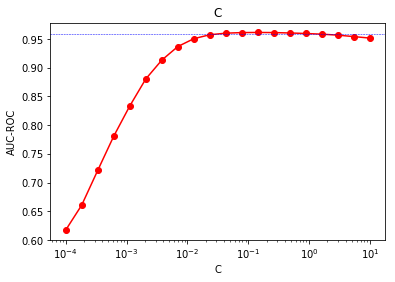

In [79]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('C')
# горизонтальная линия -- качество модели с коэффициентом по умолчанию
plt.axhline(y=score_C_1, linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

In [87]:
C=Cs[pd.DataFrame(scores).idxmax()][0]
print (C, pd.DataFrame(scores).max())

0.12742749857 0    0.961357
dtype: float64


In [88]:
# подготовим данные для обучения и теста
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning','session_time']+delta_columns])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# обучим модель на всей выборке с оптимальным коэффициентом регуляризации
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)

# сделаем прогноз для тестовой выборки
y_test = lr.predict_proba(X_test)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, 'baseline_2_with_seconds_delta.csv')